In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# from math import pi

# def norm_sq_of_wf_over_r_on_uniform_grid_polar_box(wf, dr):
#     """Evalaute the norm square of the given wavefunction array
    
#     Parameters
#     ----------
#     wf : (..., Nm, Nr) array-like
#         a single or an array of wavefunction arrays
#         with each wavefunction of shape (Nm, Nr)
#     dr : float
#         a grid spacing of the radial grid
#     """
#     _wf = np.asarray(wf)
#     _Nr = _wf.shape[-1]
#     _r_arr = dr * np.arange(1,_Nr+1)
#     _wf_abs_sq = np.real(wf.conj() * wf)
#     return 2.* pi * dr * np.sum(np.sum(_wf_abs_sq / _r_arr, axis=-1), axis=-1)

# def normalize_wf_over_r_on_uniform_grid_polar_box(wf, dr):
#     _norm_sq = norm_sq_of_wf_over_r_on_uniform_grid_polar_box(wf, dr)
#     wf *= 1. / np.sqrt(_norm_sq)

# from tdse.evol import (get_M2_tridiag, get_D2_tridiag, mul_tridiag_and_diag, 
#                        get_M1_tridiag, get_D1_tridiag)
# from tdse.tridiag import tridiag_forward, tridiag_backward, get_tridiag_shape

# class Propagator_on_Uniform_Grid_Polar_Box_Over_r(object):
#     """Propagator object defined on a polar box with uniform grid"""
    
#     def __init__(self, Nr, dr, m_max, Vr=0.0, hbar=1.0, mass=1.0):
#         """Initialize
        
#         Parameters
#         ----------
#         Nr : int
#             the number of radial grid points
#         dr : float
#             the radial grid spacing
#         m_max : int
#             maximum azimuthal quantum number 'm'
#         Vr : (Nr,) array-like
#             radially symmetric potential values
            
#         Notes
#         -----
#         The total wavefunction is expanded as:
        
#         .. math::
        
#             \\psi(r,\\phi,t) = 
#             \\frac{1}{r}\\sum_{m=-m_{max}}^{m_{max}}
#             {g_{m}(r,t)e^{im\\phi}}
#         """
        
#         # Check argumetns
#         if Nr != int(Nr) or not (Nr > 0):
#             _msg = "`Nr` should be a positive integer. Given: {}"
#             raise ValueError(_msg.format(Nr))
#         self.Nr = int(Nr)
        
#         if not (float(dr) > 0):
#             _msg = "`dr` should be positive real number. Given: {}"
#             raise ValueError(_msg.format(dr))
#         self.dr = float(dr)
        
#         if m_max != int(m_max) or m_max < 0:
#             _msg = "`m_max` should be nonnegative integer. Given: {}"
#             raise ValueError(_msg.format(m_max))
#         self.m_max = int(m_max)
        
#         self.Nm = 2 * self.m_max + 1
#         self.m_iter = range(-self.m_max, self.m_max+1)
        
#         if Vr == 0.0: self.Vr = np.zeros((self.Nr,), dtype=np.float)
#         else:
#             _Vr = np.asarray(Vr)
#             if _Vr.shape != (self.Nr,):
#                 _msg = "`Vr` should be of shape ({},). Given shape: {}"
#                 raise ValueError(_msg.format(self.Nr, _Vr.shape))
#             self.Vr = _Vr
        
#         self.hbar, self.mass = hbar, mass
        
        
#         # Evaluate matrices for constructing propagator
#         self.r_arr = self.dr * np.arange(1, self.Nr+1)
#         self.r_max = self.r_arr[-1] + dr
#         self.M2 = get_M2_tridiag(self.Nr)
        
#         if self.M2.shape != get_tridiag_shape(self.Nr):
#             raise Exception("Unexpected inner inconsistency on tridiag shape")
        
#         _M2Hm_shape = (self.Nm,) + get_tridiag_shape(self.Nr)
#         self.M2Hm = np.empty(_M2Hm_shape, dtype=self.Vr.dtype) 
        
#         _D2 = get_D2_tridiag(self.Nr, self.dr)
        
#         _hbar2m = 0.5 * self.hbar**2 / self.mass
#         _Kr = - _hbar2m * _D2  # something like radial kinetic energy
        
#         _r_sq_arr = np.square(self.r_arr)
#         for _im, _m in enumerate(self.m_iter):
#             _Vm = self.Vr - _hbar2m * (1-_m*_m) / _r_sq_arr
#             _M2Vm = mul_tridiag_and_diag(self.M2, _Vm)
#             self.M2Hm[_im,:,:] = _Kr + _M2Vm
        
#         _D1 = get_D1_tridiag(self.Nr, self.dr)
#         self.M1H1 = _hbar2m * _D1 / self.r_arr
#         self.M1 = get_M1_tridiag(self.Nr)
    
            
#     def propagate(self, wf, dt, Nt=1):
#         """Propagate given wavefunction by a given timestep
        
#         Parameters
#         ----------
#         wf : (Nm, Nr) or (Nm*Nr,) array-like
#             array of wavefunction values
#             where `Nm` is the number of azimuthal basis
#             and `Nr` is the number of radial grid points
#         dt : float
#             timestep to propagate
#         Nt : int
#             number of timesteps
#         """
#         _wf = wf
#         _wf_1d = np.ravel(wf)
#         if _wf_1d.shape != (self.Nm * self.Nr,):
#             _msg = ("Inconsistent wavefunction shape given: {}\n"
#                     "It should be possible to flatten the shape into: {}")
#             raise ValueError(_msg.format(_wf_1d.shape, (self.Nm * self.Nr,)))
        
#         if Nt != int(Nt) or not (Nt > 0):
#             _msg = "`Nt` should be a positive integer"
#             raise ValueError(_msg.format(Nr))
#         _Nt = int(Nt)
        
#         _FO = (-0.5j*dt/self.hbar) * self.M2Hm
#         _unitary_shape = (3,)+_wf_1d.shape
#         _unitary_forward_half = np.swapaxes(self.M2+_FO, 0, 1).reshape(_unitary_shape)
#         _unitary_backward_half = np.swapaxes(self.M2-_FO, 0, 1).reshape(_unitary_shape)
        
#         _FO1 = (-0.25j*dt/self.hbar)*self.M1H1
#         _uni1_forward_half_half = self.M1 + _FO1
#         _uni1_backward_half_half = self.M1 - _FO1
        
        
        
#         # Iterate over time
#         _wf_1d_half = np.empty_like(_wf_1d, dtype=complex)
#         _wf_m_half = np.empty((self.Nr,), dtype=complex)
        
#         for _it in range(_Nt):
            
#             for _im in range(self.Nm):
#                 tridiag_forward(_uni1_forward_half_half, _wf[_im], _wf_m_half)
#                 tridiag_backward(_uni1_backward_half_half, _wf[_im], _wf_m_half)
            
#             tridiag_forward(_unitary_forward_half, _wf_1d, _wf_1d_half)
#             tridiag_backward(_unitary_backward_half, _wf_1d, _wf_1d_half)
            
#             for _im in range(self.Nm):
#                 tridiag_forward(_uni1_forward_half_half, _wf[_im], _wf_m_half)
#                 tridiag_backward(_uni1_backward_half_half, _wf[_im], _wf_m_half)
            
            
#     def propagate_to_ground_state(self, wf, dt=None, max_Nt=20000, Nt_per_iter=10, 
#                                   norm_thres=1e-13):
#         """Propagate the given wavefunction to the ground state of this system"""
#         if dt is None: _dt = self.dr / 4.
#         else:
#             _dt = float(dt)
#             if not (_dt > 0): 
#                 _msg = "`dt` should be a positive real number. Given: {}"
#                 raise ValueError(_msg.format(_dt))
#         _imag_dt = -1.0j * _dt  # imaginary time for propagating to ground state
        
#         normalize_wf_over_r_on_uniform_grid_polar_box(wf, self.dr)
#         _wf_prev = wf.copy()
        
#         _max_iter = int(max_Nt / Nt_per_iter) + 1
#         for _i in range(_max_iter):
#             self.propagate(wf, _imag_dt, Nt=Nt_per_iter)
#             normalize_wf_over_r_on_uniform_grid_polar_box(wf, self.dr)
#             _norm = norm_sq_of_wf_over_r_on_uniform_grid_polar_box(wf-_wf_prev, self.dr)
#             if _norm < norm_thres: break
#             _wf_prev = wf.copy()
#         if _i >= _max_iter-1: raise Exception("Maximum iteration exceeded")
#         else: print("iteration count at end: {}".format(_i))

In [3]:
from tdse.propagator.polar import Propagator_on_Uniform_Grid_Polar_Box_Over_r

prop = Propagator_on_Uniform_Grid_Polar_Box_Over_r(Nr=101, dr=0.2, m_max=1, Vr=0.0)

In [4]:
wf = np.zeros((prop.Nm, prop.Nr), dtype=complex)
wf[2] = np.random.rand(prop.Nr)

In [5]:
prop.propagate_to_ground_state(wf, norm_thres=1e-10)

iteration count at end: 331


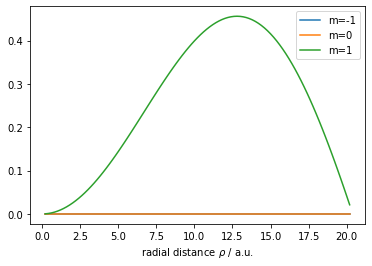

In [6]:
fig, ax = plt.subplots()
for im, m in enumerate(prop.m_iter):
    ax.plot(prop.r_arr, wf[im].real, label='m={}'.format(m))
ax.set_xlabel(r"radial distance $\rho$ / a.u.")
ax.legend()

In [7]:
from scipy.special import jn, jn_zeros

j0_zero_0, = jn_zeros(0, 1)
j0_r = jn(0, j0_zero_0 * prop.r_arr / prop.r_max)
g0_r_ana = prop.r_arr * j0_r
prop.wf_class.normalize(g0_r_ana, prop.dr)

j1_zero_0, = jn_zeros(1, 1)
j1_r = jn(1, j1_zero_0 * prop.r_arr / prop.r_max)
g1_r_ana = prop.r_arr * j1_r
prop.wf_class.normalize(g1_r_ana, prop.dr)

g0_r_num = wf[1]
g1_r_num = wf[2]

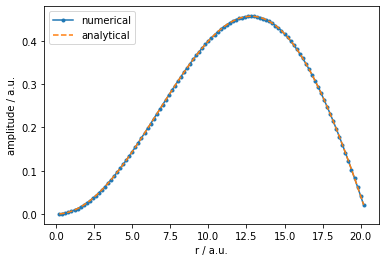

In [8]:
g_ana = g1_r_ana
g_num = g1_r_num

fig, ax = plt.subplots()

lnum, = ax.plot(prop.r_arr, g_num.real, '.-', label='numerical')
# ax.plot(prop.r_arr, np.abs(g_num), color=lnum.get_color(), linewidth=0.7)

ax.plot(prop.r_arr, g_ana, '--', label='analytical')

ax.set_xlabel("r / a.u."), ax.set_ylabel("amplitude / a.u.")
ax.legend()
# fig.savefig("ground-state-prototype-with-spilt-op-m-1-test-5.png")

# [TODO] Let's boost to match the slope at r=0 to the analytical one. What can be a proper procedure?

![ddd](ground-state-prototype-with-spilt-op-dr-0.1.png)

- let's check the .. D1 and M1 .. let's think how to change them

In [9]:
# from numpy import pi
# class Wavefunction_on_Uniform_Grid_Polar_Box_Over_r(object):
#     @staticmethod
#     def eval_at_real_space(wf, dr, phi):
#         _phi = np.asarray(phi)
#         if _phi.ndim == 0 and int(_phi) == _phi: _phi = np.linspace(0, 2.*pi, int(_phi))
#         elif _phi.ndim == 1: pass
#         else: raise ValueError("Unacceptable given `phi`: {}".format(phi))
        
#         _wf = np.asarray(wf)
#         if _wf.ndim == 1: _wf.reshape((1,_wf.size))
#         elif _wf.ndim == 2: pass
#         else: raise ValueError("Unacceptable wf dimension: {}".format(_wf.ndim))
#         _Nm, _Nr = _wf.shape
        
#         assert (_Nm % 2) == 1
#         _max_m = int(_Nm // 2)
#         _m_arr = np.arange(-_max_m, _max_m+1, dtype=int)
#         _exp_imphi = np.exp(1.j*np.outer(_m_arr, _phi))
        
#         _r_arr = dr * np.arange(1, _Nr+1)
        
#         _wf_real_space = np.einsum(_wf, [0, 1], _exp_imphi, [0, 2], [2, 1]) / _r_arr
#         return _wf_real_space

In [10]:
phi_arr = np.linspace(0., 2.*np.pi, 101)
wf_polar = prop.wf_class.eval_at_real_space(wf, prop.dr, phi_arr)

In [11]:
from vis.plot import construct_polar_mesh_for_colormesh
r_cmesh, phi_cmesh = construct_polar_mesh_for_colormesh(prop.r_arr, phi_arr)

(Text(0.5, 0, 'x / a.u.'), Text(0, 0.5, 'y / a.u.'))

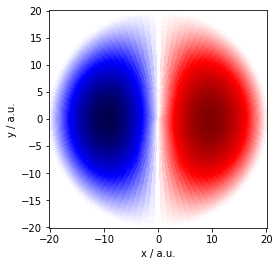

In [12]:
fig, ax = plt.subplots()
vmax = np.abs(wf_polar).max()
ax.pcolormesh(r_cmesh, phi_cmesh, wf_polar.transpose().real, cmap='seismic', vmin=-vmax, vmax=vmax)
ax.set_aspect(1.0)
ax.set_xlabel("x / a.u."), ax.set_ylabel("y / a.u.")

# fig.savefig("wf-real-space-reconst-test-2.png")

# [TODO] Evaluate the energy and compare

- be careful to evaluate the energy with Numerov-boosted Hamiltonian

# [TODO] implement c-boosted version of gaussian ellimination